In [ ]:
!pip install volmdlr==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.9/942.9 KB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 KB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# IMPORTS
import volmdlr
from volmdlr import Point2D, Vector3D
from volmdlr.core import VolumeModel
from volmdlr.wires import ClosedPolygon2D
from volmdlr.primitives3d import ExtrudedProfile

In [ ]:
# DATA
raw_I = [(0.773757, 0.609392), (0.774033, 1.609945), (0.975691, 1.610221), (0.975414, 0.609669)]

raw_F = [
    (1.074033, 0.409669),
    (1.074033, 1.410221),
    (1.673757, 1.409945),
    (1.674309, 1.251657),
    (1.274586, 1.251657),
    (1.274586, 1.009669),
    (1.624033, 1.009669),
    (1.624309, 0.851657),
    (1.274309, 0.851934),
    (1.274586, 0.409392),
]

coord_I = [(round(x - raw_I[0][0], 2), round(y - raw_I[0][1], 2)) for (x, y) in raw_I]
coord_F = [(round(x - raw_F[0][0], 2), round(y - raw_F[0][1], 2)) for (x, y) in raw_F]

coord_FF = [
    [(0.0, 0.0), (0.0, 0.44), (0.2, 0.44), (0.2, 0.0)],
    [(0.0, 0.44), (0.0, 0.6), (0.55, 0.6), (0.55, 0.44)],
    [(0.0, 0.6), (0.0, 0.84), (0.2, 0.84), (0.2, 0.6)],
    [(0.0, 0.84), (0.0, 1.0), (0.6, 1.0), (0.6, 0.84)],
]

In [ ]:
# HEIGHT OPTIMIZATION
LARGEUR_TRUSS = 0.289
LARGEUR_LAMBOURDE = 0.063
EPAISSEUR_CONTREPLAQUE = 0.005

largeur_opti = LARGEUR_TRUSS + 2 * LARGEUR_LAMBOURDE + 2 * EPAISSEUR_CONTREPLAQUE
hauteur_opti = coord_I[1][1] / coord_I[2][0] * largeur_opti
HAUTEUR = hauteur_opti
print(f"Hauteur: {HAUTEUR}m\n")

Hauteur: 2.125m



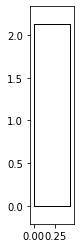

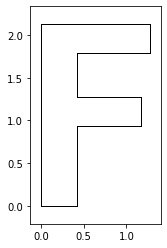

In [ ]:
# GEOMETRY COMPUTING
coord_I_scaled = [(x * HAUTEUR, y * HAUTEUR) for (x, y) in coord_I]
coord_F_scaled = [(x * HAUTEUR, y * HAUTEUR) for (x, y) in coord_F]
coord_FF_scaled = [[(x * HAUTEUR, y * HAUTEUR) for (x, y) in coord] for coord in coord_FF]

points_I = [Point2D(x, y) for (x, y) in coord_I_scaled]
points_F = [Point2D(x, y) for (x, y) in coord_F_scaled]
points_FF = [[Point2D(x, y) for (x, y) in coord] for coord in coord_FF_scaled]

contour_I = ClosedPolygon2D(points_I)
contour_F = ClosedPolygon2D(points_F)
contours_FF = [ClosedPolygon2D(points) for points in points_FF]

contour_I.plot()
contour_F.plot()

volume_I = ExtrudedProfile(
    volmdlr.O3D, volmdlr.X3D, volmdlr.Z3D, contour_I, [], volmdlr.Y3D * points_I[0].point_distance(points_I[-1])
)

volume_F = ExtrudedProfile(
    volmdlr.O3D, volmdlr.X3D, volmdlr.Z3D, contour_F, [], volmdlr.Y3D * points_F[0].point_distance(points_F[-1])
)

volume_FF = VolumeModel(
    [
        ExtrudedProfile(
            volmdlr.O3D,
            volmdlr.X3D,
            volmdlr.Z3D,
            contour,
            [],
            volmdlr.Y3D * contour.points[0].point_distance(contour.points[-1]),
        )
        for contour in contours_FF
    ]
)

In [ ]:
# 3D REPRESENTATION

volume_FF_positioned = volume_FF.translation(Vector3D(0.4 * HAUTEUR, 0.4 * HAUTEUR, 0.0))
structure = VolumeModel([volume_I] + volume_FF_positioned.primitives)

from IPython.display import HTML


structure.save_babylonjs_to_file(filename="/tmp/strucure")
HTML(filename="/tmp/strucure.html")

In [ ]:
# GEOMETRY AND PRICE ESTIMATION

# LENGTH ESTIMATION

length_I = 4 * contour_I.primitives[0].length() + 6 * contour_I.primitives[1].length()
length_FF = sum(4 * contour.primitives[0].length() + 6 * contour.primitives[1].length() for contour in contours_FF)

print(f"Longueur estimé I: {round(length_I, 2)}m")
print(f"Longueur estimé FF: {round(length_FF, 2)}m")
print(f"Longueur estimé totale: {round(length_I+length_FF, 2)}m\n")

# AREA ESTIMATION

area_I = round(sum(p.surface2d.area() for p in volume_I.primitives), 2)
area_FF = round(sum(sum(p.surface2d.area() for p in volume.primitives) for volume in volume_FF.primitives), 2)

print(f"Surface estimé I: {area_I}m²")
print(f"Surface estimé FF: {area_I+area_FF}m²")
print(f"Surface estimé totale: {area_FF}m²\n")

# PRICE ESTIMATION
# https://www.leroymerlin.fr/produits/materiaux/bois-de-charpente-bois-brut-et-dalle-de-construction/ossature-bois-et-bois-de-charpente/chevron-lambourde-et-bastaing/lambourde-1-2-chevron-sapin-traite-38x63-mm-longueur-4-m-choix-2-classe-2-70028252.html?src=clk
# https://www.leroymerlin.fr/produits/menuiserie/panneau-planche-et-materiaux-bois/panneau-bois-agglomere-mdf/panneau-bois-recoupable/panneau-contreplaque-ordinaire-ep-5-mm-x-l-250-x-l-122-cm-67292694.html?src=clk

PRICE_PER_M = 6.3 / 4
PRICE_PER_M2 = 23.9 / (2.5 * 1.22)

prix_lambourde = round(PRICE_PER_M * (length_I + length_FF), 2)
prix_contreplaque = round(PRICE_PER_M2 * (area_I + area_FF), 2)

print(f"Coût lambourde estimé: {prix_lambourde}€")
print(f"Coût contreplaqué estimé: {prix_contreplaque}€")
print(f"Coût total estimé: {round(prix_lambourde+prix_contreplaque, 2)}€")


Longueur estimé I: 11.05m
Longueur estimé FF: 28.26m
Longueur estimé totale: 39.31m

Surface estimé I: 3.97m²
Surface estimé FF: 16.46m²
Surface estimé totale: 12.49m²

Coût lambourde estimé: 61.92€
Coût contreplaqué estimé: 128.98€
Coût total estimé: 190.9€
